Importing Tensorflow, NP, OS, PIL

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# To run only on CPU:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

Getting Data

In [6]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

data_dir = pathlib.Path("./Dataset")

GPUs Available:  []


In [7]:
image_count = len(list(data_dir.glob("*/*.jp*g")))
print(image_count)

data_dir

14566


WindowsPath('Dataset')

Visualizing Data!

In [4]:
guns = list(data_dir.glob('Guns/*'))

for i in range(0, 5):
    val = PIL.Image.open(str(guns[i]))
    val.show()

In [5]:
no_guns = list(data_dir.glob('No Guns/*'))

for i in range(0, 5):
    val = PIL.Image.open(str(no_guns[i]))
    val.show()

Load Data!

In [8]:
batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 14571 files belonging to 2 classes.
Using 11657 files for training.
Found 14571 files belonging to 2 classes.
Using 2914 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Guns', 'No Guns']


Visualizing Dataset!

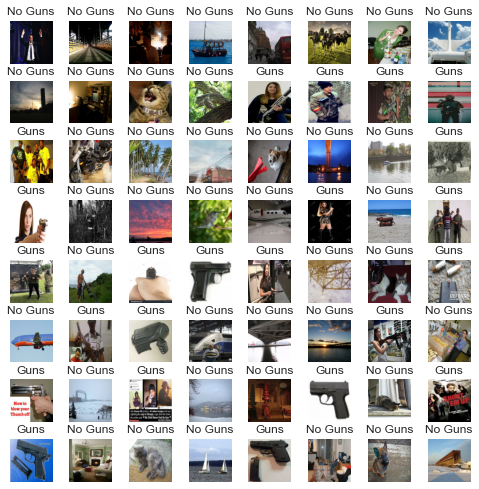

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(8, 8))

for images, labels in train_ds.take(1):
    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]], fontsize=12)
        plt.axis("off")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.savefig("sample_img.jpg")
plt.show()

In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


Configure for Performance!

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the Data

In [24]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9982245


Create the Neural Network!

In [33]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(16, 1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Conv2D(32, 1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Conv2D(64, 1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.Conv2D(128, 1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.Conv2D(256, 1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      1056      
                                                        

Compile the Neural Network!

In [34]:
model.compile(optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", "mse"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      1056      
                                                        

Training!!!!

In [35]:
epochs=8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
183/183 [==============================] - 190s 1s/step - loss: 0.6495 - accuracy: 0.6438 - mse: 0.7746 - val_loss: 0.5888 - val_accuracy: 0.7008 - val_mse: 0.8439
Epoch 2/8
183/183 [==============================] - 196s 1s/step - loss: 0.5397 - accuracy: 0.7305 - mse: 1.1557 - val_loss: 0.4636 - val_accuracy: 0.7817 - val_mse: 1.4995
Epoch 3/8
183/183 [==============================] - 192s 1s/step - loss: 0.4183 - accuracy: 0.8117 - mse: 1.8930 - val_loss: 0.3846 - val_accuracy: 0.8270 - val_mse: 1.6475
Epoch 4/8
183/183 [==============================] - 192s 1s/step - loss: 0.3587 - accuracy: 0.8513 - mse: 2.2795 - val_loss: 0.3277 - val_accuracy: 0.8648 - val_mse: 3.2784
Epoch 5/8
183/183 [==============================] - 187s 1s/step - loss: 0.3318 - accuracy: 0.8615 - mse: 2.6773 - val_loss: 0.3100 - val_accuracy: 0.8706 - val_mse: 2.7381
Epoch 6/8
183/183 [==============================] - 189s 1s/step - loss: 0.2958 - accuracy: 0.8799 - mse: 3.2352 - val_loss: 0.30

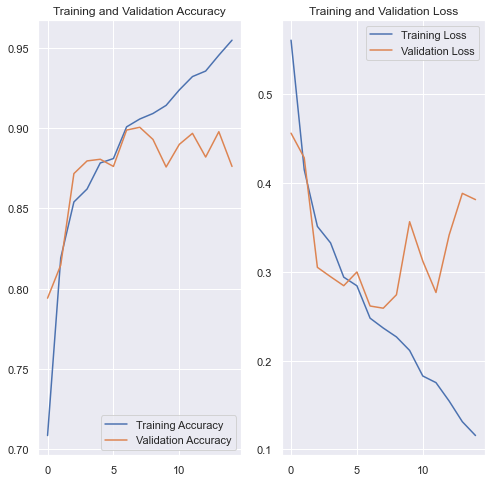

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Reading 31 images...


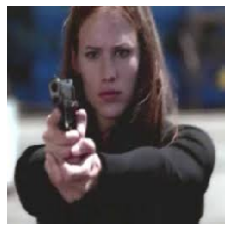

tf.Tensor([0.99838424 0.00161577], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 99.84 percent confidence.
Time to predict: 0.27s


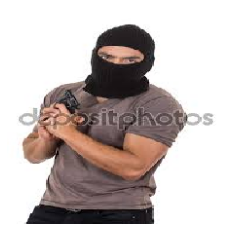

tf.Tensor([0.9957306 0.0042694], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 99.57 percent confidence.
Time to predict: 0.03s


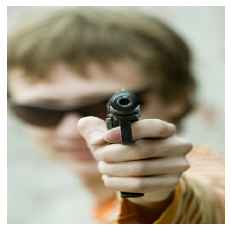

tf.Tensor([0.96994877 0.03005123], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 96.99 percent confidence.
Time to predict: 0.03s


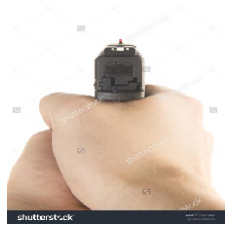

tf.Tensor([0.85876924 0.14123078], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 85.88 percent confidence.
Time to predict: 0.03s


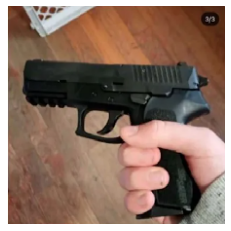

tf.Tensor([0.99486923 0.00513078], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 99.49 percent confidence.
Time to predict: 0.03s


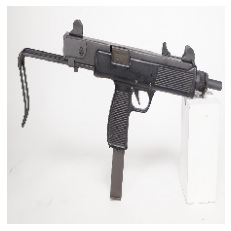

tf.Tensor([9.9999332e-01 6.6979655e-06], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 100.00 percent confidence.
Time to predict: 0.03s


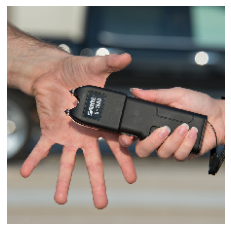

tf.Tensor([8.1375655e-04 9.9918622e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.92 percent confidence.
Time to predict: 0.03s


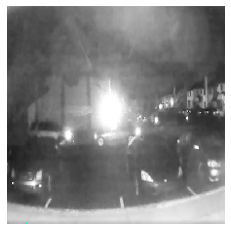

tf.Tensor([5.3746106e-08 1.0000000e+00], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 100.00 percent confidence.
Time to predict: 0.03s


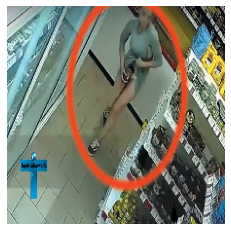

tf.Tensor([0.00287414 0.9971258 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.71 percent confidence.
Time to predict: 0.03s


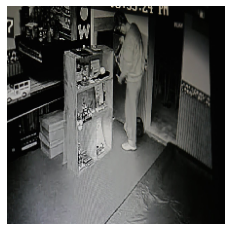

tf.Tensor([0.21124274 0.78875726], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 78.88 percent confidence.
Time to predict: 0.03s


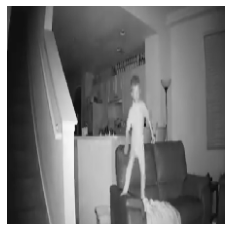

tf.Tensor([0.06275097 0.93724906], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 93.72 percent confidence.
Time to predict: 0.03s


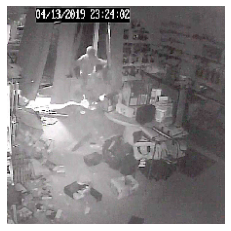

tf.Tensor([9.970975e-08 9.999999e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 100.00 percent confidence.
Time to predict: 0.03s


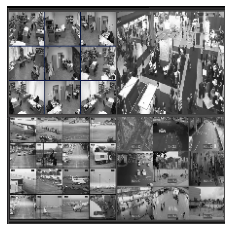

tf.Tensor([4.9136014e-04 9.9950862e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.95 percent confidence.
Time to predict: 0.03s


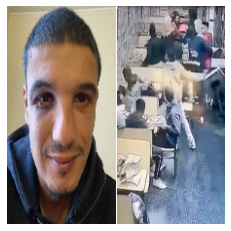

tf.Tensor([0.04175577 0.9582442 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 95.82 percent confidence.
Time to predict: 0.03s


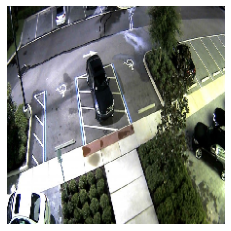

tf.Tensor([4.1871713e-06 9.9999583e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 100.00 percent confidence.
Time to predict: 0.03s


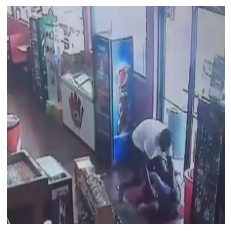

tf.Tensor([0.12271757 0.87728244], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 87.73 percent confidence.
Time to predict: 0.04s


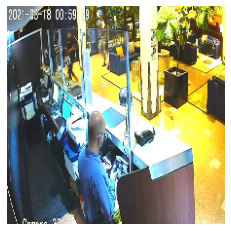

tf.Tensor([4.5060905e-04 9.9954933e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.95 percent confidence.
Time to predict: 0.03s


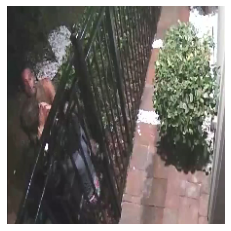

tf.Tensor([0.32525638 0.67474365], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 67.47 percent confidence.
Time to predict: 0.03s


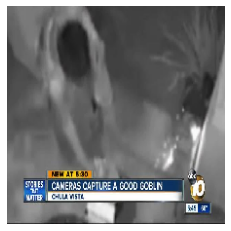

tf.Tensor([9.9981946e-01 1.8052770e-04], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 99.98 percent confidence.
Time to predict: 0.04s


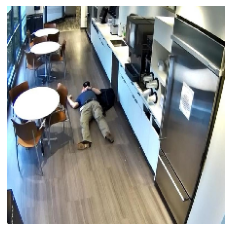

tf.Tensor([0.72058314 0.2794169 ], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 72.06 percent confidence.
Time to predict: 0.03s


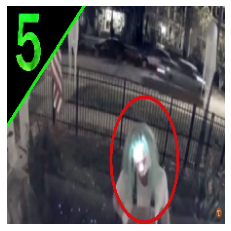

tf.Tensor([0.0023871  0.99761295], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.76 percent confidence.
Time to predict: 0.03s


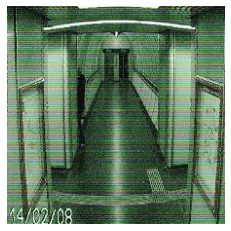

tf.Tensor([0.00248134 0.99751866], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.75 percent confidence.
Time to predict: 0.03s


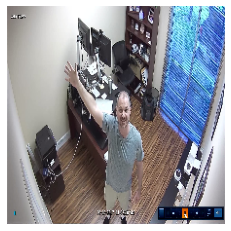

tf.Tensor([0.02503284 0.9749672 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 97.50 percent confidence.
Time to predict: 0.03s


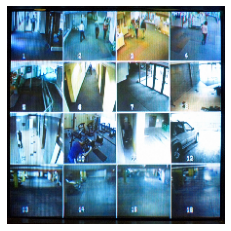

tf.Tensor([1.5286727e-04 9.9984705e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.98 percent confidence.
Time to predict: 0.04s


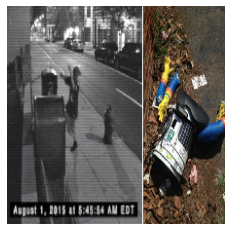

tf.Tensor([0.0262297 0.9737704], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 97.38 percent confidence.
Time to predict: 0.03s


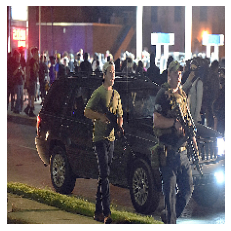

tf.Tensor([7.090856e-05 9.999291e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.99 percent confidence.
Time to predict: 0.03s


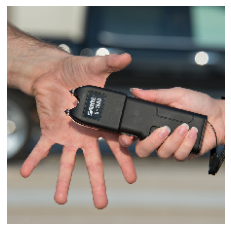

tf.Tensor([8.1375655e-04 9.9918622e-01], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.92 percent confidence.
Time to predict: 0.03s


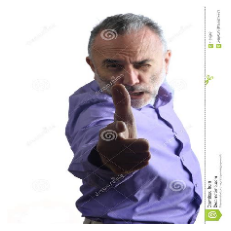

tf.Tensor([0.8580918  0.14190827], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 85.81 percent confidence.
Time to predict: 0.03s


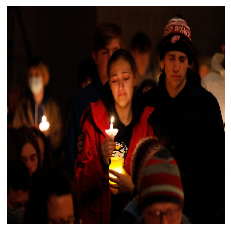

tf.Tensor([0.994422   0.00557798], shape=(2,), dtype=float32)
This image most likely belongs to Guns with a 99.44 percent confidence.
Time to predict: 0.03s


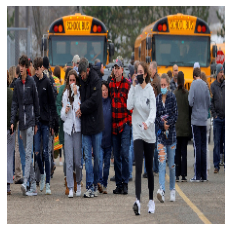

tf.Tensor([0.00114124 0.9988588 ], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.89 percent confidence.
Time to predict: 0.03s


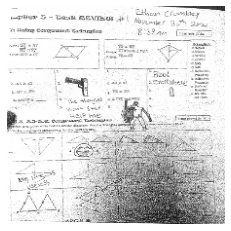

tf.Tensor([0.00694736 0.99305266], shape=(2,), dtype=float32)
This image most likely belongs to No Guns with a 99.31 percent confidence.
Time to predict: 0.03s


In [29]:
import time

gun_paths = list(pathlib.Path("Validation_Test").glob("*"))
print(F"Reading {len(gun_paths)} images...")

for gun_path in gun_paths:
    img = tf.keras.utils.load_img(
        gun_path, target_size=(img_height, img_width)
    )

    plt.imshow(img)
    plt.axis("off")
    plt.show()

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    start = time.time()
    predictions = model.predict(img_array)

    score = tf.nn.softmax(predictions[0])
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print("Time to predict: {:.2f}s".format(time.time() - start))